In [1]:
import itertools
import json
import os
from random import sample

import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from database import data_utils
from models import avg_speed
from models import time_table

import importlib
importlib.reload(data_utils)

<module 'database.data_utils' from '/Users/zack/Desktop/valle/src/database/data_utils.py'>

In [2]:
# Read in DeepTTE results
kcm_deeptte_preds = pd.read_csv("../results/kcm2weeks/deeptte.res", delimiter=" ", header=None)
kcm_deeptte_preds.columns = ["label", "pred"]

nwy_deeptte_preds = pd.read_csv("../results/nwy2weeks/deeptte.res", delimiter=" ", header=None)
nwy_deeptte_preds.columns = ["label", "pred"]

In [43]:
# Read in config file
with open("../results/kcm2weeks/data/config.json") as f:
    kcm_config = json.load(f)

with open("../results/nwy2weeks/data/config.json") as f:
    nwy_config = json.load(f)

In [45]:
# Read in train data
kcm_train_data = []
for i in range(0,5):
    kcm_contents = open("../results/kcm2weeks/data/train_0"+str(i), "r").read()
    kcm_train_data.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_train_data = list(itertools.chain.from_iterable(kcm_train_data))

nwy_train_data = []
for i in range(0,5):
    nwy_contents = open("../results/nwy2weeks/data/train_0"+str(i), "r").read()
    nwy_train_data.append([json.loads(str(item)) for item in nwy_contents.strip().split('\n')])
nwy_train_data = list(itertools.chain.from_iterable(nwy_train_data))

In [ ]:
# Read in test data
kcm_contents = open("../results/kcm2weeks/data/test", "r").read()
kcm_test_data = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

nwy_contents = open("../results/nwy2weeks/data/test", "r").read()
nwy_test_data = [json.loads(str(item)) for item in nwy_contents.strip().split('\n')]

In [6]:
# Resample GPS points to fixed number
kcm_train_data_resample = data_utils.resample_deeptte_gps(kcm_train_data, 128)
kcm_test_data_resample = data_utils.resample_deeptte_gps(kcm_test_data, 128)

nwy_train_data_resample = data_utils.resample_deeptte_gps(nwy_train_data, 128)
nwy_test_data_resample = data_utils.resample_deeptte_gps(nwy_test_data, 128)

In [7]:
# Reshape the resampled GPS data to a 2d np array for train/testing additional models
X_train_kcm, y_train_kcm = data_utils.format_deeptte_to_features(kcm_train_data, kcm_train_data_resample)
X_test_kcm, y_test_kcm = data_utils.format_deeptte_to_features(kcm_test_data, kcm_test_data_resample)

X_train_nwy, y_train_nwy = data_utils.format_deeptte_to_features(nwy_train_data, nwy_train_data_resample)
X_test_nwy, y_test_nwy = data_utils.format_deeptte_to_features(nwy_test_data, nwy_test_data_resample)

In [46]:
# Train and test using hourly average speeds
kcm_avg = avg_speed.AvgHourlySpeedModel()
kcm_avg.fit(kcm_train_data)
kcm_avg_preds = kcm_avg.predict(kcm_test_data)

nwy_avg = avg_speed.AvgHourlySpeedModel()
nwy_avg.fit(nwy_train_data)
nwy_avg_preds = nwy_avg.predict(nwy_test_data)

In [47]:
# Use schedule model to make preds on test data
with open('../results/kcm2weeks/data/test_traces.pkl', 'rb') as f:
    kcm_test_traces = pickle.load(f)
kcm_sch = time_table.TimeTableModel("../data/kcm_gtfs/2022_09_19/", "America/Los_Angeles")
kcm_sch_preds, kcm_sch_labels, kcm_lost = kcm_sch.predict_using_schedule_only(kcm_test_traces)
print("KCM Lost: "+str(kcm_lost)) # Should be 0

with open('../results/nwy2weeks/data/test_traces.pkl', 'rb') as f:
    nwy_test_traces = pickle.load(f)
nwy_sch = time_table.TimeTableModel("../data/nwy_gtfs/2022_12_01/", "Europe/Oslo")
nwy_sch_preds, nwy_sch_labels, nwy_lost = nwy_sch.predict_using_schedule_only(nwy_test_traces)
print("NWY Lost: "+str(nwy_lost)) # Should be 0

# Give the schedule model the benefit of the doubt and remove anything with an error over 15 minutes (there are some large outliers)
kcm_residuals = kcm_sch_labels - kcm_sch_preds
kcm_sch_labels2 = kcm_sch_labels[kcm_residuals<900]
kcm_sch_preds2 = kcm_sch_preds[kcm_residuals<900]

nwy_residuals = nwy_sch_labels - nwy_sch_preds
nwy_sch_labels2 = nwy_sch_labels[nwy_residuals<900]
nwy_sch_preds2 = nwy_sch_preds[nwy_residuals<900]

KCM Lost: 0.0
NWY Lost: 0.0


In [ ]:
# Train GBDT on training data, make preds on test data
kcm_reg = GradientBoostingRegressor(random_state=0)
kcm_reg.fit(X_train_kcm, y_train_kcm)
GradientBoostingRegressor(random_state=0)
kcm_gbdt_preds = kcm_reg.predict(X_test_kcm)

nwy_reg = GradientBoostingRegressor(random_state=0)
nwy_reg.fit(X_train_nwy, y_train_nwy)
GradientBoostingRegressor(random_state=0)
nwy_gbdt_preds = nwy_reg.predict(X_test_nwy)

In [48]:
# Compare different methods for predicting travel times of the test data
model_performances = {
    "MAPE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_percentage_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_percentage_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(nwy_avg_preds, [x['time'] for x in nwy_test_data]),
            "SCH": metrics.mean_absolute_percentage_error(nwy_sch_preds2, nwy_sch_labels2)
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_percentage_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_percentage_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_percentage_error(kcm_avg_preds, [x['time'] for x in kcm_test_data]),
            "SCH": metrics.mean_absolute_percentage_error(kcm_sch_preds, kcm_sch_labels)
        }
    },
    "RMSE": {
        "Trondheim": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred)),
            "GBDT": np.sqrt(metrics.mean_squared_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(nwy_avg_preds, [x['time'] for x in nwy_test_data])),
            "SCH": np.sqrt(metrics.mean_squared_error(nwy_sch_preds, nwy_sch_labels)),
        },
        "Seattle": {
            "DeepTTE": np.sqrt(metrics.mean_squared_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred)),
            "GBDT": np.sqrt(metrics.mean_squared_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data])),
            "AVG": np.sqrt(metrics.mean_squared_error(kcm_avg_preds, [x['time'] for x in kcm_test_data])),
            "SCH": np.sqrt(metrics.mean_squared_error(kcm_sch_preds, kcm_sch_labels)),
        }
    },
    "MAE": {
        "Trondheim": {
            "DeepTTE": metrics.mean_absolute_error(nwy_deeptte_preds.label, nwy_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_error(nwy_gbdt_preds, [x['time'] for x in nwy_test_data]),
            "AVG": metrics.mean_absolute_error(nwy_avg_preds, [x['time'] for x in nwy_test_data]),
            "SCH": metrics.mean_absolute_error(nwy_sch_preds, nwy_sch_labels)
        },
        "Seattle": {
            "DeepTTE": metrics.mean_absolute_error(kcm_deeptte_preds.label, kcm_deeptte_preds.pred),
            "GBDT": metrics.mean_absolute_error(kcm_gbdt_preds, [x['time'] for x in kcm_test_data]),
            "AVG": metrics.mean_absolute_error(kcm_avg_preds, [x['time'] for x in kcm_test_data]),
            "SCH": metrics.mean_absolute_error(kcm_sch_preds, kcm_sch_labels)
        }
    }
}
model_performances_df = []
for metric in model_performances.keys():
    df = pd.DataFrame(model_performances[metric]).reset_index()
    df = df.melt(id_vars="index", value_vars=['Trondheim', 'Seattle'])
    df['Metric'] = metric
    model_performances_df.append(df)
model_performances_df = pd.concat(model_performances_df)
model_performances_df.columns = ["Model","City","value","Metric"]
model_performances_df

,Model,City,value,Metric
0,DeepTTE,Trondheim,0.086576,MAPE
1,GBDT,Trondheim,0.127635,MAPE
2,AVG,Trondheim,0.317259,MAPE
3,SCH,Trondheim,0.226608,MAPE
4,DeepTTE,Seattle,0.142112,MAPE
5,GBDT,Seattle,0.153147,MAPE
6,AVG,Seattle,0.672819,MAPE
7,SCH,Seattle,0.219258,MAPE
0,DeepTTE,Trondheim,329.799330,RMSE
1,GBDT,Trondheim,292.090103,RMSE


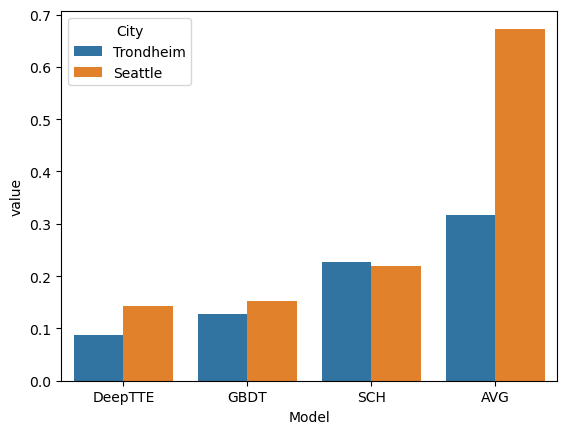

In [49]:
# Plot accuracy across all models
fig, ax = plt.subplots(1,1)
model_performances_df_plot = model_performances_df.sort_values(['value'])
sns.barplot(model_performances_df_plot[model_performances_df_plot['Metric']=='MAPE'], x="Model", y="value", hue="City")
plt.savefig("../plots/model_performances.png", dpi=1800, bbox_inches='tight')

In [ ]:
# List of feature names for understanding importance
feature_names = ['timeID','weekID','dateID','driverID','dist']
feature_names = feature_names + [f"lat_{x}" for x in range(128)]
feature_names = feature_names + [f"lng_{x}" for x in range(128)]

In [ ]:
# Sort importances and names
nwy_features_sorted = [x for _, x in sorted(zip(nwy_reg.feature_importances_, feature_names))][::-1]
nwy_importances_sorted = [_ for _, x in sorted(zip(nwy_reg.feature_importances_, feature_names))][::-1]
kcm_features_sorted = [x for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]
kcm_importances_sorted = [_ for _, x in sorted(zip(kcm_reg.feature_importances_, feature_names))][::-1]

# Read out names and importances of top n
print(nwy_features_sorted[:10])
print(kcm_features_sorted[:10])

In [ ]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(nwy_features_sorted[:10], nwy_importances_sorted[:10])
plt.savefig("../plots/nwy_gbdt_importances.png", dpi=1800, bbox_inches='tight')

In [ ]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(kcm_features_sorted[:10], kcm_importances_sorted[:10])
plt.savefig("../plots/kcm_gbdt_importances.png", dpi=1800, bbox_inches='tight')

In [ ]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(nwy_features_sorted[1:], nwy_importances_sorted[1:])
plt.savefig("../plots/nwy_gbdt_non_dist_importances.png", dpi=1800, bbox_inches='tight')

In [ ]:
# Plot importances
fig, ax = plt.subplots(1,1)
plt.bar(kcm_features_sorted[1:], kcm_importances_sorted[1:])
plt.savefig("../plots/kcm_gbdt_non_dist_importances.png", dpi=1800, bbox_inches='tight')